# Test notebook S3

This notebook can be used to test a besca version to ensure that everything is still functional including S3 cloud storage.

It shows some analysis results presentations and should be checked before a release.

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

In [2]:
import scanpy.api as sc
import besca as bc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import s3fs

/pstore/home/hatjek/.conda/envs/besca_s3/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/pstore/home/hatjek/.conda/envs/besca_s3/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,
/pstore/home/hatjek/.conda/envs/besca_s3/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



# Configure output dir (local file system or S3 bucket)

In [3]:
# Write files to local file system
#outdir_base = '/tmp/'
#s3_fs=s3_fs=None
#s3_bucket=None

# Write files to S3 bucket
outdir_base = ''
S3_PROFILE_NAME=os.environ['S3_PROFILE_NAME']
S3_ENDPOINT_URL=os.environ['S3_ENDPOINT_URL']
S3_BUCKET=os.environ['S3_BUCKET']
s3_fs = s3fs.S3FileSystem(
    anon=False, 
    profile_name=S3_PROFILE_NAME, # Use credentials from the [RSIROSS] section of ~/.aws/credentials 
    client_kwargs={'endpoint_url': S3_ENDPOINT_URL} # Set endpoint URL to ROSS
)
s3_bucket = S3_BUCKET

# testing of helper functions

In [4]:
adata = bc.datasets.pbmc3k_processed()
adata_raw = bc.get_raw(adata)

# testing of count functions

In [5]:
adata = bc.datasets.pbmc_storage_processed()

In [6]:
adata

AnnData object with n_obs × n_vars = 27901 × 1433 
    obs: 'CELL', 'CONDITION', 'experiment', 'sample_type', 'storage_condition', 'donor', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'louvain', 'celltype'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells', 'total_counts', 'frac_reads', 'mean', 'mean_log1p', 'coeffvar', 'coeffvar_log1p'
    uns: 'donor_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'storage_condition_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [7]:
bc.tl.count_occurance_subset(adata=adata, count_variable='louvain', subset_variable='donor')

,Donor_3A,Donor_1,Donor_2
0,1810,1412,1018
1,1921,1345,901
10,119,121,137
11,70,120,46
12,93,31,22
2,1382,1499,1003
3,1284,655,1421
4,1613,989,693
5,1539,697,792
6,650,397,545


In [8]:
bc.tl.count_occurance_subset_conditions(adata, subset_variable = 'storage_condition', count_variable = 'louvain', condition_identifier = 'donor', )

,Count 24h_RT Donor_3A,Count 24h_RT Donor_1,Count 24h_RT Donor_2,Count fresh Donor_3A,Count fresh Donor_2,Count fresh Donor_1,Count frozen Donor_3A,Count frozen Donor_2,Count frozen Donor_1
0,578,295,212,633,380,527,599,426,590
1,997,1006,550,824,272,233,100,79,106
10,49,41,46,37,41,47,33,50,33
11,27,30,10,26,15,33,17,21,57
12,54,19,4,32,9,10,7,9,2
2,748,1153,647,517,254,241,117,102,105
3,650,395,605,413,493,137,221,323,123
4,682,487,237,624,306,343,307,150,159
5,800,385,374,615,306,233,124,112,79
6,135,115,114,298,248,171,217,183,111


In [9]:
fig = bc.pl.celllabel_quant_boxplot(adata, count_variable = 'louvain', subset_variable = 'donor', condition_identifier = 'storage_condition',  plot_percentage = True);

In [10]:
fig = bc.pl.celllabel_quant_stackedbar(adata, count_variable = 'louvain', subset_variable = 'donor');

In [11]:
fig = bc.pl.louvain_quant_stackedbar(adata, subset_variable = 'donor')

# Testing with PBMC3k Dataset

In [12]:
adata = bc.datasets.pbmc3k_raw()

In [13]:
#define thresholds
min_genes = 600
min_cells = 2
min_UMI = 600
max_UMI = 6500
max_mito = 0.05
max_genes = 1900

#define outdir
outdir = outdir_base + 'besca_test/pbmc3k/'

#set randomseed
random_seed = 0

In [14]:
#visualize filtering thresholds
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6))= plt.subplots(ncols=3, nrows=2)
fig.set_figwidth(15)
fig.set_figheight(8)
fig.tight_layout(pad=4.5)

bc.pl.kp_genes(adata, min_genes=min_genes, ax = ax1)
bc.pl.kp_cells(adata, min_cells=min_cells, ax = ax2)
bc.pl.kp_counts(adata, min_counts=min_UMI, ax = ax3)
bc.pl.max_counts(adata, max_counts=max_UMI, ax = ax4)
bc.pl.max_mito(adata, max_mito=max_mito, annotation_type='SYMBOL', species='human', ax = ax5)
bc.pl.max_genes(adata, max_genes=max_genes)

adding percent mitochondrial genes to dataframe for species human


/pstore/data/bioinfo/users/hatjek/devel/besca_s3/besca/pl/_filter_threshold_plots.py:390: RuntimeWarning:

invalid value encountered in true_divide



In [15]:
#perform filtering of the thresholds
adata = bc.pp.filter(adata, max_counts=max_UMI, max_genes=max_genes, max_mito=max_mito,min_genes=min_genes, min_counts=min_UMI, min_cells=min_cells)

started with  737280  total cells and  32738  total genes
removed 15 cells that expressed more than 1900 genes
removed 734965 cells that did not express at least 600  genes
removed 4 cells that had more than 6500  counts
removed 0 cells that did not have at least 600 counts
removed 17843 genes that were not expressed in at least 2 cells
removed  17  cells that expressed  5.0 percent mitochondrial genes or more
finished with 2279  total cells and 14895 total genes


In [16]:
sc.pl.violin(adata, ['n_counts', 'n_genes', 'percent_mito'], multi_panel=True, jitter = 0.4)

In [17]:
#normalize our data (not an internal besca function)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4) 

#log transform normalized UMI-counts (+1 offset) and store as new "raw" data
adata.raw = sc.pp.log1p(adata, copy=True)

In [18]:
%%time
#export our data
bc.export.X_to_mtx(adata=adata, outpath=os.path.join(outdir, 'analyzed', 'ANALYSIS_NAME','normalized_counts', 'cp10k'), write_metadata=True, geneannotation='SYMBOL', additional_geneannotation='ENSEMBL', s3_fs=s3_fs, s3_bucket=s3_bucket)

writing out matrix.mtx ...
adata.X successfully written to matrix.mtx
genes successfully written out to genes.tsv
cellbarcodes successfully written out to barcodes.tsv
annotation successfully written out to metadata.tsv
CPU times: user 5.98 s, sys: 221 ms, total: 6.2 s
Wall time: 7.42 s


In [19]:
%%time

# Compare to local file system write out

#export our data
bc.export.X_to_mtx(adata=adata, outpath=os.path.join(outdir, 'analyzed', 'ANALYSIS_NAME','normalized_counts', 'cp10k'), write_metadata=True, geneannotation='SYMBOL', additional_geneannotation='ENSEMBL')

writing out matrix.mtx ...
adata.X successfully written to matrix.mtx
genes successfully written out to genes.tsv
cellbarcodes successfully written out to barcodes.tsv
annotation successfully written out to metadata.tsv
CPU times: user 4.61 s, sys: 200 ms, total: 4.81 s
Wall time: 6.9 s


In [20]:
#identify genes with variable expression
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean = 0.0125, max_mean=5, min_disp = 0.5) 
sc.pl.filter_genes_dispersion(filter_result)
nbr_variable_genes = sum(filter_result.gene_subset)
print('number of variable genes selected ', nbr_variable_genes )

#apply filter on data
adata = adata[:, filter_result.gene_subset]

#log transform our data
sc.pp.log1p(adata)

#regress-out
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

#scale data
sc.pp.scale(adata, max_value=10)

number of variable genes selected  1724


/pstore/home/hatjek/.conda/envs/besca_s3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning:

Revieved a view of an AnnData. Making a copy.



In [21]:
sc.tl.pca(adata, random_state=random_seed, svd_solver='arpack')

sc.pp.neighbors(adata, n_neighbors=10, random_state = random_seed)

sc.tl.umap(adata, random_state = random_seed)

sc.tl.leiden(adata, random_state = random_seed)

#plot clusters
sc.settings.set_figure_params(dpi=90)
sc.pl.umap(adata, color=['leiden'], projection='2d', edgecolor = 'none')

#also perform TSNE
sc.tl.tsne(adata)
sc.pl.tsne(adata, color = ['leiden'])

In [22]:
#write out regressed counts
bc.export.X_to_mtx(adata, outpath=os.path.join(outdir, 'analyzed', 'ANALYSIS_NAME', 'normalized_counts', 'regressedOut'), geneannotation='SYMBOL', write_metadata= True, additional_geneannotation='ENSEMBL', s3_fs=s3_fs, s3_bucket=s3_bucket)

writing out matrix.mtx ...
adata.X successfully written to matrix.mtx
genes successfully written out to genes.tsv
cellbarcodes successfully written out to barcodes.tsv
annotation successfully written out to metadata.tsv


In [23]:
#export values saved in .raw
#this is an example of how to use this function, in this case we don't need it 
#bc.export.raw_to_mtx(adata, outpath=os.path.join(outdir, 'analyzed', 'ANALYSIS_NAME', 'normalized_counts', 'regressedOut_raw'), geneannotation='SYMBOL', write_metadata= True, additional_geneannotation='ENSEMBL')

In [24]:
bc.export.clustering(adata, outpath = os.path.join(outdir,'analyzed', 'ANALYSIS_NAME', 'labelings', 'louvain'))
bc.export.labeling_info(outpath=os.path.join(outdir,'analyzed', 'ANALYSIS_NAME', 'labelings', 'louvain'))

mapping of cells to  leiden exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out


In [25]:
bc.export.analysis_metadata(adata, outpath=os.path.join(outdir,'analyzed', 'ANALYSIS_NAME'), n_pcs= 3, umap=True, tsne=True)

results successfully written out to 'analysis_metadata.tsv'


In [26]:
#marker gene analysis
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', use_raw = True, n_genes = adata.raw.X.shape[1])

In [27]:
#export rank files
bc.export.ranked_genes(adata=adata, outpath=os.path.join(outdir,'analyzed', 'ANALYSIS_NAME', 'labelings', 'louvain'), type='wilcox')

besca_test/pbmc3k/analyzed/ANALYSIS_NAME/labelings/louvain/WilxRank.gct written out
besca_test/pbmc3k/analyzed/ANALYSIS_NAME/labelings/louvain/WilxRank.pvalues.gct written out
besca_test/pbmc3k/analyzed/ANALYSIS_NAME/labelings/louvain/WilxRank.logFC.gct written out


In [28]:
#plot markers documented in Seurat tutorial to label celltypes
sc.pl.umap(adata=adata, color = ['leiden'], edgecolor = 'none')

In [29]:
new_labels = ["mixed", #0
              "mixed", #1
              "CD14+ monocyte", #2
              "mixed", #3
              "B-cell", #4
              "FCGR3A+ monocyte", #5
              "mixed", #6
              "pDC"] #7

bc.tl.annotate_cells_clustering(adata, new_labels, new_annotation_label = 'celltype', clustering_label = 'leiden')

In [30]:
#preserve these less well defined labels for some plotting examples later on
adata.obs['highlevel_celltype'] = adata.obs.get('celltype').tolist()

In [31]:

#bc.tl.sig.combined_signature_score(adata=adata, GMT_file= '../besca/datasets/genesets/Immune.gmt', use_raw=True, verbose = False)

In [32]:
#sc.pl.umap(adata, color= [col for col in adata.obs.columns if 'Bcell'  in col],
#      color_map='viridis', projection='2d'
#            )

# Demonstrate additional BESCA features

## reclustering and exporting new celltype annotations:

you can choose clusters you wish to subcluster, here in the example 0, 1, 3, 6 since they can't easily be held appart

In [33]:
adata_subset = bc.tl.rc.recluster(adata, celltype=('0', '1', '3', '6'), celltype_label = 'leiden',
                                  resolution = 1.3, method='leiden')

In total 1404 highly variable genes selected within cluster


In [34]:
sc.pl.umap(adata_subset, color = ['leiden', 'CD3G', 'CD8A', 'CD4', 'IL7R', 'NKG7', 'GNLY'])

... storing 'highlevel_celltype' as categorical


In [35]:
adata.obs.head()

,CELL,CONDITION,experiment,donor,n_counts,n_genes,percent_mito,leiden,celltype,highlevel_celltype
index,,,,,,,,,,
AAACATACAACCAC-1,AAACATACAACCAC-1,healthy PBMC,pbmc3k_besca,donor1,2421.0,781,0.030153,1,mixed,mixed
AAACATTGAGCTAC-1,AAACATTGAGCTAC-1,healthy PBMC,pbmc3k_besca,donor1,4903.0,1352,0.037936,3,mixed,mixed
AAACATTGATCAGC-1,AAACATTGATCAGC-1,healthy PBMC,pbmc3k_besca,donor1,3148.0,1131,0.008892,1,mixed,mixed
AAACCGTGCTTCCG-1,AAACCGTGCTTCCG-1,healthy PBMC,pbmc3k_besca,donor1,2639.0,960,0.017431,5,FCGR3A+ monocyte,FCGR3A+ monocyte
AAACGCACTGGTAC-1,AAACGCACTGGTAC-1,healthy PBMC,pbmc3k_besca,donor1,2163.0,782,0.016636,1,mixed,mixed


In [36]:
new_labels = ["CD4 T-cell", #0
              "CD4 T-cell", #1
              "NK cell", #2
              "CD8 T-cell", #3
              "CD8 T-cell", #4
              "CD8 T-cell", #5
              "CD4 T-cell",#6
              "CD8 T-cell", #7
              "CD4 T-cell", #8
              "CD4 T-cell", #9
              "CD4 T-cell", #10
              "CD4 T-cell",#11
              "CD4 T-cell",#12
#              "CD4 T-cell" #13
             ]

bc.tl.rc.annotate_new_cellnames(adata, adata_subset, names=new_labels, method='leiden')

NOTE: overwriting labels for the selected cells saved in adata.obs.celltype with the new labels


In [37]:
adata.obs.head()

,CELL,CONDITION,experiment,donor,n_counts,n_genes,percent_mito,leiden,celltype,highlevel_celltype
index,,,,,,,,,,
AAACATACAACCAC-1,AAACATACAACCAC-1,healthy PBMC,pbmc3k_besca,donor1,2421.0,781,0.030153,1,CD8 T-cell,mixed
AAACATTGAGCTAC-1,AAACATTGAGCTAC-1,healthy PBMC,pbmc3k_besca,donor1,4903.0,1352,0.037936,3,CD4 T-cell,mixed
AAACATTGATCAGC-1,AAACATTGATCAGC-1,healthy PBMC,pbmc3k_besca,donor1,3148.0,1131,0.008892,1,CD4 T-cell,mixed
AAACCGTGCTTCCG-1,AAACCGTGCTTCCG-1,healthy PBMC,pbmc3k_besca,donor1,2639.0,960,0.017431,5,FCGR3A+ monocyte,FCGR3A+ monocyte
AAACGCACTGGTAC-1,AAACGCACTGGTAC-1,healthy PBMC,pbmc3k_besca,donor1,2163.0,782,0.016636,1,CD4 T-cell,mixed


In [38]:
adata.obs.celltype.value_counts()

CD4 T-cell          798
CD8 T-cell          490
CD14+ monocyte      365
B-cell              255
FCGR3A+ monocyte    189
NK cell             168
pDC                  14
Name: celltype, dtype: int64

In [39]:
#export celltypes
bc.export.labeling(adata=adata, outpath = os.path.join(outdir,'analyzed', 'ANALYSIS_NAME', 'labelings', 'celltype'), column='celltype')
bc.export.labeling_info(outpath = os.path.join(outdir,'analyzed', 'ANALYSIS_NAME', 'labelings', 'celltype'), method='manual celltype annotation based on marker expression', annotated_version_of='louvain', expert=True,default=False, public=False, reference=True, description='manual celltype annotation based on the expression of marker genes')

mapping of cells to  celltype exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out


## Adding an already done labeling into your adata object

In [40]:
#note many of the entries in celltype will be named not labeled since they were filtered out before the proper labeling was performed
adata = bc.datasets.pbmc3k_raw()
adata.obs.head()

,CELL,CONDITION,experiment,donor
index,,,,
AAACATACAAAACG-1,AAACATACAAAACG-1,healthy PBMC,pbmc3k_besca,donor1
AAACATACAAAAGC-1,AAACATACAAAAGC-1,healthy PBMC,pbmc3k_besca,donor1
AAACATACAAACAG-1,AAACATACAAACAG-1,healthy PBMC,pbmc3k_besca,donor1
AAACATACAAACGA-1,AAACATACAAACGA-1,healthy PBMC,pbmc3k_besca,donor1
AAACATACAAAGCA-1,AAACATACAAAGCA-1,healthy PBMC,pbmc3k_besca,donor1


In [41]:
bc.Import.add_cell_labeling(adata, os.path.join(outdir,'analyzed', 'ANALYSIS_NAME', 'labelings', 'celltype'), label='celltype')

In [42]:
adata.obs.head()

,CELL,CONDITION,experiment,donor,celltype
index,,,,,
AAACATACAAAACG-1,AAACATACAAAACG-1,healthy PBMC,pbmc3k_besca,donor1,not labeled
AAACATACAAAAGC-1,AAACATACAAAAGC-1,healthy PBMC,pbmc3k_besca,donor1,not labeled
AAACATACAAACAG-1,AAACATACAAACAG-1,healthy PBMC,pbmc3k_besca,donor1,not labeled
AAACATACAAACGA-1,AAACATACAAACGA-1,healthy PBMC,pbmc3k_besca,donor1,not labeled
AAACATACAAAGCA-1,AAACATACAAAGCA-1,healthy PBMC,pbmc3k_besca,donor1,not labeled


# Testing with PMBC raw dataset

In [43]:
adata = bc.datasets.pbmc_storage_raw()

In [44]:
#define thresholds
min_genes = 600
min_cells = 2
min_UMI = 1600
max_UMI = 15000
max_mito = 0.15
max_genes = 3000

#define outdir
outdir = outdir_base + 'besca_test/pbmc_storage/'
#set randomseed
random_seed = 0

In [45]:
#visualize filtering thresholds
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6))= plt.subplots(ncols=3, nrows=2)
fig.set_figwidth(15)
fig.set_figheight(8)
fig.tight_layout(pad=4.5)

bc.pl.kp_genes(adata, min_genes=min_genes, ax = ax1)
bc.pl.kp_cells(adata, min_cells=min_cells, ax = ax2)
bc.pl.kp_counts(adata, min_counts=min_UMI, ax = ax3)
bc.pl.max_counts(adata, max_counts=max_UMI, ax = ax4)
bc.pl.max_mito(adata, max_mito=max_mito, annotation_type='SYMBOL', species='human', ax = ax5)
bc.pl.max_genes(adata, max_genes=max_genes)

adding percent mitochondrial genes to dataframe for species human


In [46]:
#perform filtering of the thresholds
adata = bc.pp.filter(adata, max_counts=max_UMI, max_genes=max_genes, max_mito=max_mito,min_genes=min_genes, min_counts=min_UMI, min_cells=min_cells)

started with  13066  total cells and  19883  total genes
removed 16 cells that expressed more than 3000 genes
removed 3178 cells that did not express at least 600  genes
removed 4 cells that had more than 15000  counts
removed 386 cells that did not have at least 1600 counts
removed 4980 genes that were not expressed in at least 2 cells
removed  29  cells that expressed  15.0 percent mitochondrial genes or more
finished with 9453  total cells and 14903 total genes


In [47]:
sc.pl.violin(adata, ['n_counts', 'n_genes', 'percent_mito'], multi_panel=True, jitter = 0.4)

In [48]:
#normalize our data (not an internal besca function)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4) 

#log transform normalized UMI-counts (+1 offset) and store as new "raw" data
adata.raw = sc.pp.log1p(adata, copy=True)

In [49]:
#export our data
bc.export.X_to_mtx(adata=adata, outpath=os.path.join(outdir, 'analyzed', 'ANALYSIS_NAME','normalized_counts', 'cp10k'), write_metadata=True, geneannotation='SYMBOL', additional_geneannotation='ENSEMBL', s3_fs=s3_fs, s3_bucket=s3_bucket)

writing out matrix.mtx ...
adata.X successfully written to matrix.mtx
genes successfully written out to genes.tsv
cellbarcodes successfully written out to barcodes.tsv
annotation successfully written out to metadata.tsv


In [50]:
#identify genes with variable expression
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean = 0.0125, max_mean=5, min_disp = 0.5) 
sc.pl.filter_genes_dispersion(filter_result)
nbr_variable_genes = sum(filter_result.gene_subset)
print('number of variable genes selected ', nbr_variable_genes )

#apply filter on data
adata = adata[:, filter_result.gene_subset]

#log transform our data
sc.pp.log1p(adata)

#regress-out
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

#scale data
sc.pp.scale(adata, max_value=10)

number of variable genes selected  1320


/pstore/home/hatjek/.conda/envs/besca_s3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning:

Revieved a view of an AnnData. Making a copy.



In [51]:
sc.tl.pca(adata, random_state=random_seed, svd_solver='arpack')

sc.pp.neighbors(adata, n_neighbors=10, random_state = random_seed)

sc.tl.umap(adata, random_state = random_seed)

sc.tl.louvain(adata, random_state = random_seed)

#plot clusters
sc.settings.set_figure_params(dpi=90)
sc.pl.umap(adata, color=['louvain'], projection='2d', edgecolor = 'none')

#also perform TSNE
sc.tl.tsne(adata)
sc.pl.tsne(adata, color = ['louvain'])

/pstore/home/hatjek/.conda/envs/besca_s3/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../home/hatjek/.conda/envs/besca_s3/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^


/pstore/home/hatjek/.conda/envs/besca_s3/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.

In [52]:
#write out regressed counts
# THIS IS SLOW
bc.export.X_to_mtx(adata, outpath=os.path.join(outdir, 'analyzed', 'ANALYSIS_NAME', 'normalized_counts', 'regressedOut'), geneannotation='SYMBOL', write_metadata= True, additional_geneannotation='ENSEMBL', s3_fs=s3_fs, s3_bucket=s3_bucket)

writing out matrix.mtx ...
adata.X successfully written to matrix.mtx
genes successfully written out to genes.tsv
cellbarcodes successfully written out to barcodes.tsv
annotation successfully written out to metadata.tsv


In [53]:
#export values saved in .raw
#this is an example of how to use this function, in this case we don't need it 
#bc.export.raw_to_mtx(adata, outpath=os.path.join(outdir, 'analyzed', 'ANALYSIS_NAME', 'normalized_counts', 'regressedOut_raw'), geneannotation='SYMBOL', write_metadata= True, additional_geneannotation='ENSEMBL')

In [54]:
bc.export.louvain(adata, outpath = os.path.join(outdir,'analyzed', 'ANALYSIS_NAME', 'labelings', 'louvain'))
bc.export.labeling_info(outpath=os.path.join(outdir,'analyzed', 'ANALYSIS_NAME', 'labelings', 'louvain'))

mapping of cells to  louvain exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out


In [55]:
bc.export.analysis_metadata(adata, outpath=os.path.join(outdir,'analyzed', 'ANALYSIS_NAME'), n_pcs= 3, umap=True, tsne=True)

results successfully written out to 'analysis_metadata.tsv'


In [56]:
#marker gene analysis
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon', use_raw = True, n_genes = adata.raw.X.shape[1])

In [57]:
#export rank files
bc.export.ranked_genes(adata=adata, outpath=os.path.join(outdir,'analyzed', 'ANALYSIS_NAME', 'labelings', 'louvain'), type='wilcox')

besca_test/pbmc_storage/analyzed/ANALYSIS_NAME/labelings/louvain/WilxRank.gct written out
besca_test/pbmc_storage/analyzed/ANALYSIS_NAME/labelings/louvain/WilxRank.pvalues.gct written out
besca_test/pbmc_storage/analyzed/ANALYSIS_NAME/labelings/louvain/WilxRank.logFC.gct written out


In [58]:
#plot markers documented in Seurat tutorial to label celltypes
sc.pl.umap(adata=adata, color = ['louvain'], edgecolor = 'none')

## Counting occurances of labels and have matching colors with the UMAP.

In [59]:
#generate a count table of the chosen count_variable
counts = bc.tl.count_occurance(adata=adata, count_variable='louvain', add_percentage=True)
display(counts)

,Counts,Percentage
0,972,10.28
1,907,9.59
2,822,8.70
3,809,8.56
4,744,7.87
5,616,6.52
6,563,5.96
7,560,5.92
8,537,5.68
9,527,5.57


In [60]:
ncolors = ( counts.shape)[0]

In [61]:
import seaborn as sns
#generate a basic bar plot of the table above with customed palette
current_palette ={str(i): sns.color_palette('colorblind', ncolors)[i] for i in range(ncolors)}
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(1, 2, 1)
ax1 = sns.barplot(data=counts, x=counts.index.tolist(), y='Counts', palette = current_palette)
plt.xticks(rotation=90)

ax2 = fig.add_subplot(1, 2, 2)
ax2 = sns.barplot(data=counts, x=counts.index.tolist(), y='Percentage', palette = current_palette)
plt.xticks(rotation=90)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 <a list of 19 Text major ticklabel objects>)

In [62]:
# Matching those with the UMAP colors
bc.pl.update_qualitative_palette( adata, palette=current_palette, group = 'louvain', checkColors=True)
#plot markers documented in Seurat tutorial to label celltypes
sc.pl.umap(adata=adata, color = ['louvain'], edgecolor = 'none')

In [63]:
adata

AnnData object with n_obs × n_vars = 9453 × 1320 
    obs: 'CELL', 'CONDITION', 'experiment', 'sample_type', 'storage_condition', 'donor', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'louvain'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

In [64]:
adata.obs.storage_condition.value_counts()

24h_RT    4190
fresh     3121
frozen    2142
Name: storage_condition, dtype: int64

In [65]:
# compare counts between two 'conditions' and output as a classic dataframe
(DF) = bc.tl.count_occurance_subset_conditions(adata=adata,
                                                                subset_variable= 'storage_condition',
                                                                condition_identifier='storage_condition',
                                                                count_variable='louvain',
                                                                return_percentage=True)
display(DF)

,Percentage 24h_RT 24h_RT,Percentage fresh fresh,Percentage frozen frozen
0,0.48,29.19,1.91
1,20.48,0.16,2.05
10,12.05,0.13,0.19
11,0.19,0.00,22.88
12,4.58,5.86,0.42
13,8.69,0.00,0.09
14,0.02,0.00,12.09
15,0.02,3.04,2.24
16,0.88,1.28,1.07
17,0.53,0.74,1.45


In [66]:
adata.obs.head()

,CELL,CONDITION,experiment,sample_type,storage_condition,donor,batch,n_counts,n_genes,percent_mito,louvain
index,,,,,,,,,,,
6.6K_inhouse_Donor_3A_24h_RT.GGCAATTCAGACGCCT-1,6.6K_inhouse_Donor_3A_24h_RT.GGCAATTCAGACGCCT-1,PBMC_healthy,6.6k_healthy_pbmc_storage_effects_inhouse,PBMC,24h_RT,Donor_3A,flowcell1,2664.0,867,0.046547,8
6.6K_inhouse_Donor_2_FROZEN.CGGCTAGAGCTATGCT-1,6.6K_inhouse_Donor_2_FROZEN.CGGCTAGAGCTATGCT-1,PBMC_healthy,6.6k_healthy_pbmc_storage_effects_inhouse,PBMC,frozen,Donor_2,flowcell1,2057.0,724,0.032572,2
6.6K_inhouse_Donor_3A_FROZEN.GCGCGATAGTTCGATC-1,6.6K_inhouse_Donor_3A_FROZEN.GCGCGATAGTTCGATC-1,PBMC_healthy,6.6k_healthy_pbmc_storage_effects_inhouse,PBMC,frozen,Donor_3A,flowcell1,4468.0,1144,0.017010,2
6.6K_inhouse_Donor_2_24h_RT.TACCTTAGTTCACGGC-1,6.6K_inhouse_Donor_2_24h_RT.TACCTTAGTTCACGGC-1,PBMC_healthy,6.6k_healthy_pbmc_storage_effects_inhouse,PBMC,24h_RT,Donor_2,flowcell1,2723.0,1009,0.053985,5
6.6K_inhouse_Donor_2_24h_RT.AACTCTTCAAGTTCTG-1,6.6K_inhouse_Donor_2_24h_RT.AACTCTTCAAGTTCTG-1,PBMC_healthy,6.6k_healthy_pbmc_storage_effects_inhouse,PBMC,24h_RT,Donor_2,flowcell1,10092.0,1941,0.033987,16


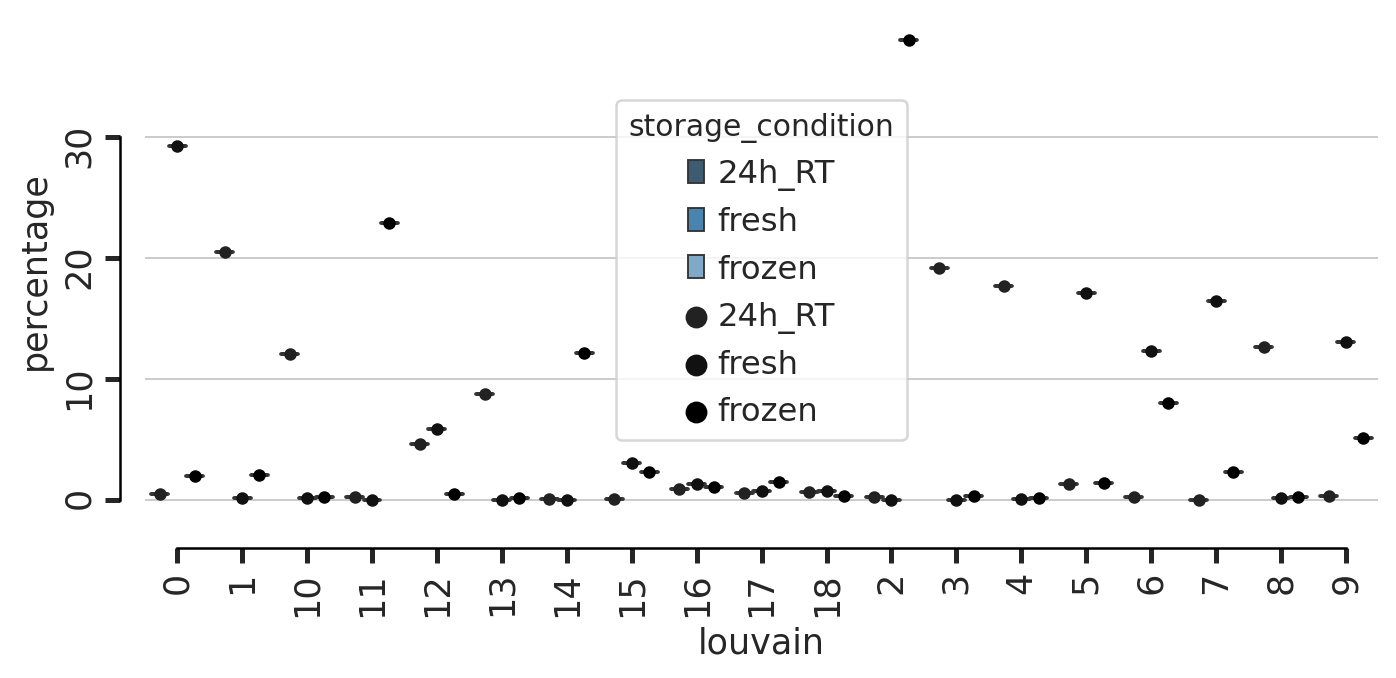

In [67]:
bc.pl.celllabel_quant_boxplot(adata, subset_variable='batch', count_variable = 'louvain', condition_identifier='storage_condition')#, save_fig = False);

# Split gene expression plots

In [68]:
adata = bc.datasets.pbmc_storage_processed()
# Split gene expression plots can only handle two conditions.
adata_subset = adata[ adata.obs['donor'] != 'Donor_1']


In [69]:
bc.pl.gene_expr_split(adata_subset, genes = ['RPS26'], split_variable= 'donor')

In [70]:
bc.pl.gene_expr_split(adata_subset, genes = ['RPS26', 'RPS4X'], split_variable= 'donor')#, #group_variable = 'condition', 
                      #split_variable='condition')

In [71]:
bc.pl.gene_expr_split(adata_subset,
                      genes = ['RPS26', 'RPS4X'], 
                      label_split_variable= 'condition', 
                     split_variable= 'donor')

# Helper function:

## Conversion

From symbol to ensembl and vice-versa.

In [72]:
bc.convert_symbol_to_ensembl( ['KRAS', 'MAP4K1'])

querying 1-2...done.
Finished.


[{'gene': 'ENSG00000133703'},
 [{'gene': 'ENSG00000282928'}, {'gene': 'ENSG00000104814'}]]

In [73]:
bc.convert_ensembl_to_symbol([ 'ENSG00000104814', 'ENSG00000282928' ])

querying 1-2...done.
Finished.


['MAP4K1', 'MAP4K1']